In [43]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import pysqkit as sq
from itertools import product, combinations
from matplotlib.lines import Line2D
from IPython.display import display, Latex, Image
import time

### Set some matplotlib parameters

In [44]:
plt.rcParams['figure.dpi'] = 100

### Define some utility functions

In [3]:
def _get_sys_states(system, comp_states):
    _energies, _states = list(zip(*[system.state(state_label) for state_label in comp_states]))
    _energies, _states = np.array(_energies), np.array(_states)
    sys_states = xr.DataArray(_states, dims=['state', 'basis_ind'], coords=dict(state=comp_states, energy=(["state"], _energies)))
    sys_states['energy'] = sys_states.energy - sys_states.energy[0]
    return sys_states

In [4]:
transmon = sq.qubits.SimpleTransmon(
    label='transmon', 
    max_freq = 6, 
    anharm = -0.3, 
    dim_hilbert = 5
)

/home/ciani/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
/home/ciani/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
/home/ciani/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
/home/ciani/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases lat

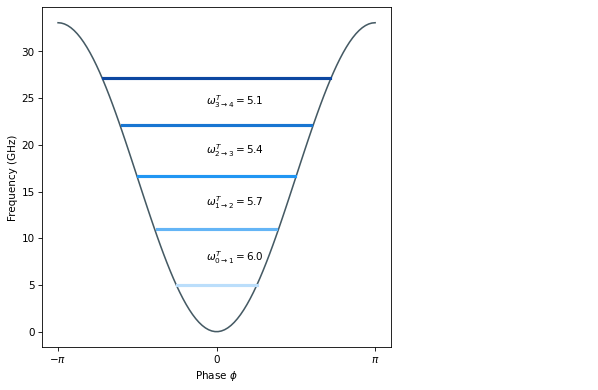

In [25]:
levels = range(5)
_ref_energy = 5 # Set some reference frequency for the ground state such that the plot looks nicer
transmon_energies = xr.DataArray(transmon.eig_energies(levels=levels) + 5, dims=['level'], coords=dict(level=levels))
phases = np.linspace(-np.pi,np.pi, 100)
_potential = (transmon.joseph_energy + transmon.potential(phases))
potential = xr.DataArray(_potential, dims=['phase'], coords=dict(phase=phases))

fig, ax = plt.subplots(1, 1, figsize=(6,6), dpi=75)
ax.plot(potential.phase, potential, '-', color='#455a64')

for level, color in zip(levels, ['#bbdefb', '#64b5f6', '#2196f3', '#1976d2', "#0d47a1"]):
    energy = transmon_energies.sel(level=level).data
    sel_phases = potential.phase.where(potential < energy, drop=True)
    ax.plot([sel_phases.min(), sel_phases.max()], [energy, energy], color=color, lw=3)
    if level > 0:
        prev_energy = transmon_energies.sel(level=level-1).data
        ax.annotate(s='', xy=(-0.25, prev_energy), xytext=(-0.25,energy), arrowprops=dict(arrowstyle='<->'))
        ax.text(-0.2, 0.5*(energy + prev_energy), r'$\omega^{{T}}_{{{} \rightarrow {}}} = {:.2}$'.format(level-1, level, energy-prev_energy), va='center', rotation='horizontal')
    
ax.set_xlabel('Phase $\phi$')
ax.set_ylabel('Frequency (GHz)')
ax.set_xticks([-np.pi, 0, np.pi])
ax.set_xticklabels([r'$-\pi$', '0', r'$\pi$'])
plt.show()

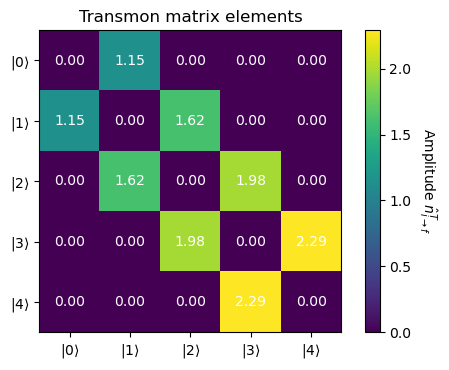

In [6]:
levels = range(5)
level_labels = [r'$\left|{}\right\rangle$'.format(level) for level in levels]
mat_elements = transmon.mat_elements(operator='charge_op', levels=levels, as_xarray=True)

fig, ax = plt.subplots()
plt.imshow(np.abs(mat_elements), cmap='viridis')

for in_level, out_level in product(levels, repeat=2):
    amplitude = abs(mat_elements.sel(in_level=in_level, out_level=out_level))
    ax.text(in_level, out_level, '{:.2f}'.format(float(amplitude)), ha="center", va="center", color="white")
    
ax.set_xticks(levels)
ax.set_yticks(levels)
ax.set_xticklabels(level_labels)
ax.set_yticklabels(level_labels)

cbar = plt.colorbar()
cbar.ax.set_ylabel(r"Amplitude $\hat{n}^{T}_{i \rightarrow f}$", rotation=-90, va="bottom")

ax.set_title('Transmon matrix elements')

plt.show()

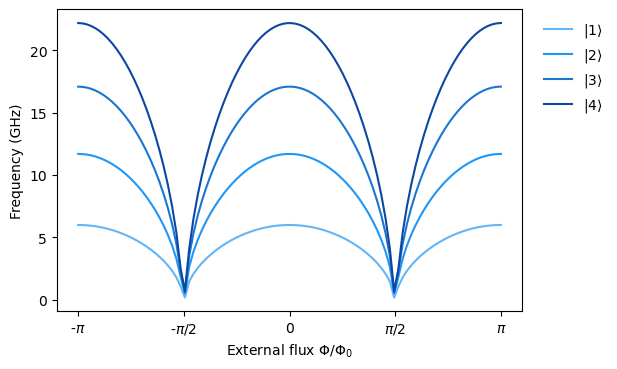

In [7]:
fluxbiases = np.linspace(-1, 1, 100)
levels = np.arange(5)
init_ext_flux = transmon.ext_flux

_energies = []
for fluxbias in fluxbiases:
    transmon.ext_flux = fluxbias
    _energies.append(transmon.eig_energies(levels=levels))
transmon.ext_flux = init_ext_flux
    
flux_scan = xr.DataArray(_energies, dims=['ext_flux', 'level'], coords=dict(ext_flux=fluxbiases, level=levels))

fig, ax = plt.subplots()
for level, color in zip(levels[1:], ['#64b5f6', '#2196f3', '#1976d2', "#0d47a1"]):
    ax.plot(flux_scan.ext_flux, flux_scan.sel(level=level), color=color, label=r'$\left|{}\right\rangle$'.format(level))

ax.set_xticks([-1, -0.5, 0, 0.5, 1])
ax.set_xticklabels([r'-$\pi$', '-$\pi$/2', r'0',  '$\pi$/2', r'$\pi$'])
ax.set_xlabel(r'External flux $\Phi/\Phi_0$')
ax.set_ylabel(r'Frequency (GHz)')

ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left', frameon=False)
plt.show()

In [8]:
fluxonium = sq.qubits.Fluxonium(
    label='fluxonium',
    joseph_energy=5.900, 
    charge_energy=0.975, 
    induct_energy=0.455,
    flux = 0.5
)
fluxonium.diagonalize_basis(5)

In [9]:
fluxonium_tran_freqs = np.diff(fluxonium.eig_energies(), 1)
for level in range(3):
    display(Latex(r'$\omega^{{f}}_{{{} \rightarrow {}}}$ = {:.3f} GHz'.format(level, level+1, fluxonium_tran_freqs[level])))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

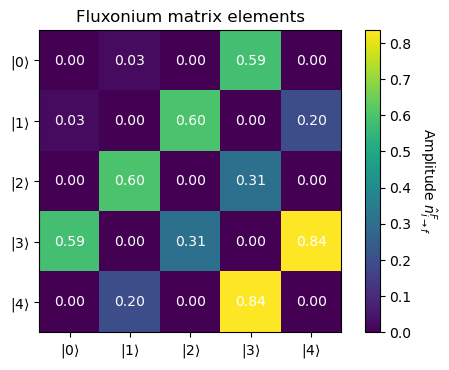

In [10]:
levels = range(5)
level_labels = [r'$\left|{}\right\rangle$'.format(level) for level in levels]
mat_elements = fluxonium.mat_elements(operator='charge_op', levels=levels, as_xarray=True)

fig, ax = plt.subplots()
plt.imshow(np.abs(mat_elements), cmap='viridis')

for in_level, out_level in product(levels, repeat=2):
    amplitude = abs(mat_elements.sel(in_level=in_level, out_level=out_level))
    ax.text(in_level, out_level, '{:.2f}'.format(float(amplitude)), ha="center", va="center", color="white")
    
ax.set_xticks(levels)
ax.set_yticks(levels)
ax.set_xticklabels(level_labels)
ax.set_yticklabels(level_labels)

cbar = plt.colorbar()
cbar.ax.set_ylabel(r"Amplitude $\hat{n}^{F}_{i \rightarrow f}$", rotation=-90, va="bottom")

ax.set_title('Fluxonium matrix elements')

plt.show()

# Inspecting the coupled transmon-fluxonium system

In [11]:
bare_system = transmon.couple_to(fluxonium, coupling=sq.couplers.capacitive_coupling, strength=0)
comp_states = [''.join(qubit_states) for qubit_states in list(product('0123', repeat=2))]

_eig_energies = bare_system.eig_energies()
_sel_inds = [bare_system.state_index(state, _eig_energies) for state in comp_states]

state_energies = xr.DataArray([_eig_energies[ind] for ind in _sel_inds], dims=['state'], coords=dict(state=comp_states))
state_energies -= state_energies.sel(state='00')

for state in comp_states:
    display(Latex(r'$\omega_{{{}}}$ = {:.3f} GHz'.format(state, float(state_energies.sel(state=state)))))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [12]:
coupling_strengths = np.linspace(0, 0.4, 200)

_eig_energies = bare_system.eig_energies()
_sel_inds = [bare_system.state_index(state, _eig_energies) for state in comp_states]

_energies = []
for strength in coupling_strengths:
    _sys = transmon.couple_to(fluxonium, coupling=sq.couplers.capacitive_coupling, strength=strength)
    eig_energies = _sys.eig_energies(levels=_sel_inds)
    _energies.append(eig_energies - eig_energies[0])
    
energies = np.array(_energies)

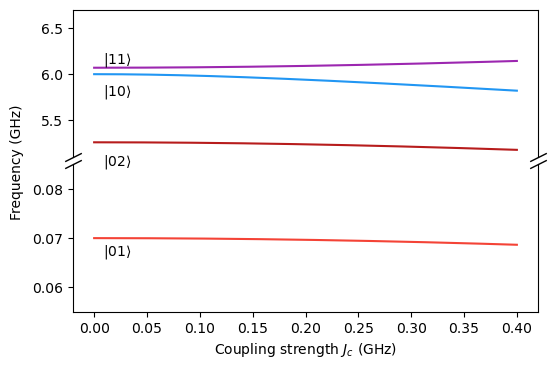

In [13]:
fig, (top_ax, bot_ax) = plt.subplots(2, 1, sharex=True)
fig.subplots_adjust(hspace=0.05) 

bot_ax.plot(coupling_strengths, energies[:,1], color='#f44336')

for i, color in zip(range(2,5), ['#b71c1c', '#2196f3', '#9c27b0']):
    top_ax.plot(coupling_strengths, energies[:,i], color=color)

bot_ax.set_ylim(0.055, 0.085)
top_ax.set_ylim(5.1, 6.7)

top_ax.spines['bottom'].set_visible(False)
bot_ax.spines['top'].set_visible(False)
top_ax.tick_params(axis='x', bottom=False)
top_ax.tick_params(labeltop=False)
bot_ax.xaxis.tick_bottom()

d = .5
kwargs = dict(marker=[(-1, -d), (1, d)], markersize=12, linestyle="none", color='k', mec='k', mew=1, clip_on=False)
bot_ax.plot([0, 1], [1, 1], transform=bot_ax.transAxes, **kwargs)
top_ax.plot([0, 1], [0, 0], transform=top_ax.transAxes, **kwargs)

bot_ax.set_xlabel(r"Coupling strength $J_{c}$ (GHz)")
fig.text(0.02, 0.5, 'Frequency (GHz)', va='center', rotation='vertical')

fig.text(0.175, 0.275, r'$\left|01\right\rangle$', va='center', rotation='horizontal')
fig.text(0.175, 0.5, r'$\left|02\right\rangle$', va='center', rotation='horizontal')
fig.text(0.175, 0.675, r'$\left|10\right\rangle$', va='center', rotation='horizontal')
fig.text(0.175, 0.755, r'$\left|11\right\rangle$', va='center', rotation='horizontal')
    
plt.show()

In [14]:
_transition_freqs = []
coup_strengths = np.linspace(0, 0.35, 40)

_eig_energies = bare_system.eig_energies()
_sel_inds = [bare_system.state_index(state, _eig_energies) for state in comp_states]

for coup_strength in coup_strengths:
    _sys = transmon.couple_to(fluxonium, coupling=sq.couplers.capacitive_coupling, strength=coup_strength)
    energies = _sys.eig_energies(levels=_sel_inds)
    energies -= energies[0]
    _transition_freqs.append(energies[:,np.newaxis] - energies)

trans_freq_scan = xr.DataArray(
    _transition_freqs, 
    dims=['coup_str', 'out_state', 'in_state'], 
    coords=dict(
        coup_str=coup_strengths, 
        out_state=comp_states, 
        in_state=comp_states
    )
)

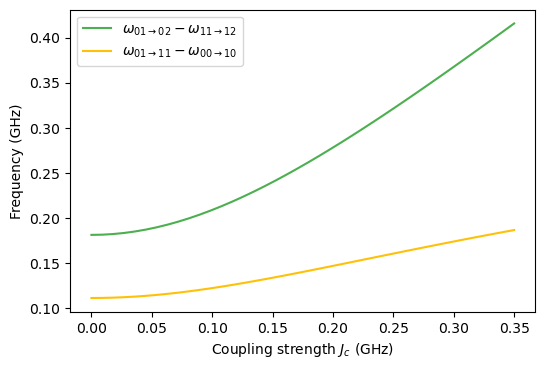

In [15]:
fig, ax = plt.subplots()

ax.plot(trans_freq_scan.coup_str, trans_freq_scan.sel(in_state='01', out_state='02') - trans_freq_scan.sel(in_state='11', out_state='12'), label=r'$\omega_{01\rightarrow02}-\omega_{11\rightarrow12}$', color='#4caf50')
ax.plot(trans_freq_scan.coup_str, trans_freq_scan.sel(in_state='01', out_state='11') - trans_freq_scan.sel(in_state='00', out_state='10'), label=r'$\omega_{01\rightarrow11}-\omega_{00\rightarrow10}$', color='#ffc107')

ax.set_ylabel('Frequency (GHz)')
ax.set_xlabel(r'Coupling strength $J_{c}$ (GHz)')
plt.legend()
plt.show()

In [16]:
_mat_elem_amplitudes = []
coup_strengths = np.linspace(0, 0.35, 40)

q_labels = [qubit.label for qubit in bare_system]

_eig_energies = bare_system.eig_energies()
_state_inds = [bare_system.state_index(state, _eig_energies) for state in comp_states]

for coup_strength in coup_strengths:
    _sys = transmon.couple_to(fluxonium, coupling=sq.couplers.capacitive_coupling, strength=coup_strength)
    _elem_amps = []
    for q_label in q_labels:
        _elem_amps.append(np.abs(_sys.mat_elements(_sys[q_label].charge_op(), levels=_state_inds)))
    _mat_elem_amplitudes.append(_elem_amps)

mat_elem_amplitude_scan = xr.DataArray(
    _mat_elem_amplitudes, 
    dims=['coup_str', 'qubit', 'out_state', 'in_state'], 
    coords=dict(
        coup_str=coup_strengths, 
        qubit=q_labels,
        out_state=comp_states, 
        in_state=comp_states
    )
)

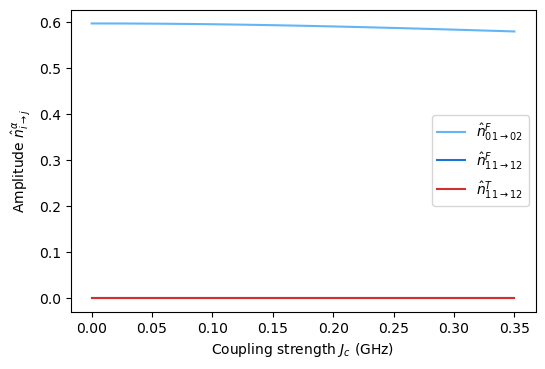

In [17]:
fig, ax = plt.subplots()

ax.plot(mat_elem_amplitude_scan.coup_str, mat_elem_amplitude_scan.sel(qubit='fluxonium', in_state='01', out_state='02'), label=r'$\hat{n}^{F}_{01 \rightarrow 02}$', color='#64b5f6')
ax.plot(mat_elem_amplitude_scan.coup_str, mat_elem_amplitude_scan.sel(qubit='fluxonium', in_state='11', out_state='12'), label=r'$\hat{n}^{F}_{11 \rightarrow 12}$', color='#1976d2')

ax.plot(mat_elem_amplitude_scan.coup_str, mat_elem_amplitude_scan.sel(qubit='transmon', in_state='11', out_state='12'), label=r'$\hat{n}^{T}_{11 \rightarrow 12}$', color='#d32f2f')

ax.set_ylabel(r'Amplitude $\hat{n}^{\alpha}_{i\rightarrow j}$')
ax.set_xlabel(r'Coupling strength $J_{c}$ (GHz)')

plt.legend()
plt.show()

In [18]:
system = transmon.couple_to(fluxonium, coupling=sq.couplers.capacitive_coupling, strength=0.2)

In [19]:
_eig_energies = bare_system.eig_energies()
_sel_inds = [bare_system.state_index(state, _eig_energies) for state in comp_states]

eig_energies = system.eig_energies(levels=_sel_inds)
eig_energies -= eig_energies[0]

state_energies = xr.DataArray(eig_energies, dims=['state'], coords=dict(state=comp_states))

bare_eig_energies = _eig_energies[_sel_inds]
bare_state_energies = xr.DataArray(bare_eig_energies - bare_eig_energies[0], dims=['state'], coords=dict(state=comp_states))

trans_freqs = xr.DataArray(
    eig_energies[:,np.newaxis] - eig_energies, 
    dims=['out_state', 'in_state'], 
    coords=dict(
        out_state=comp_states, 
        in_state=comp_states
    )
)

mat_elem_amps = xr.DataArray(
    [np.abs(_sys.mat_elements(qubit.charge_op(), levels=_sel_inds)) for qubit in system],
    dims=['qubit', 'out_state', 'in_state'], 
    coords=dict( 
        qubit=q_labels,
        out_state=comp_states, 
        in_state=comp_states
    )
)

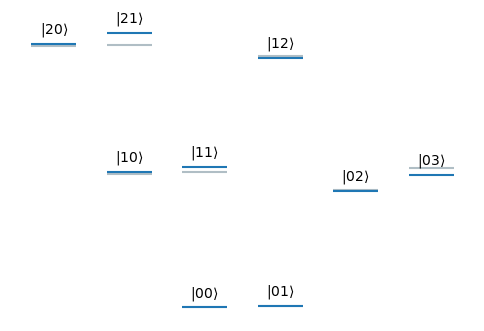

In [22]:
fig, ax = plt.subplots()

for state in ['00', '01', '02','03', '10', '11', '12', '20', '21']:
    transmon_state, fluxonium_state = (int(state_label) for state_label in state)
    exc_ind = fluxonium_state - transmon_state
    bare_energy = bare_state_energies.sel(state=state)
    energy = state_energies.sel(state=state)
    ax.hlines(bare_energy, xmin=exc_ind-0.3, xmax=exc_ind+0.3, color='#b0bec5')
    ax.hlines(energy, xmin=exc_ind-0.3, xmax=exc_ind+0.3)
    ax.text(exc_ind, energy+0.25, r'$\left|{}\right\rangle$'.format(state), va='bottom', ha='center', rotation='horizontal')
    
ax.axis('off')
plt.show()

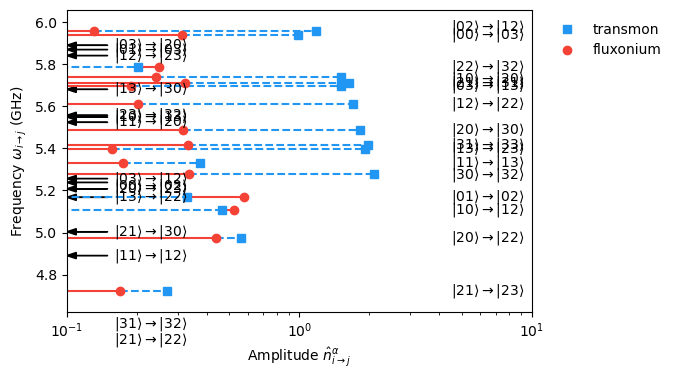

In [23]:
_min_mat_elem_bound = 1e-1
_mim_freq_bound = 4
_max_freq_bound = 6

fig, ax = plt.subplots()

_labeled_trans = dict()
_unlabeled_trans = dict()

_markers = dict(transmon='s', fluxonium='o')
_colors = dict(transmon='#2196f3', fluxonium = '#f44336')
_linestyles = dict(transmon='--', fluxonium='-')


for in_state, out_state in combinations(comp_states, 2):
    trans_freq = float(trans_freqs.sel(in_state=in_state, out_state=out_state))
    if trans_freq < _max_freq_bound and trans_freq > _mim_freq_bound:
        amp_vals = mat_elem_amps.sel(in_state=in_state, out_state=out_state)
        if any(amp_vals > _min_mat_elem_bound):
            amp_vals = amp_vals.sortby(amp_vals)
            min_val, max_val = amp_vals.data
            qubits = amp_vals.qubit.data
            for xmin, xmax, qubit in zip([0, min_val], [min_val, max_val], qubits):
                ax.hlines(trans_freq, xmin=xmin, xmax=xmax, color=_colors[qubit], linestyles=_linestyles[qubit])
                ax.plot([xmax], [trans_freq], marker=_markers[qubit], markersize=6, color=_colors[qubit])
                _labeled_trans[trans_freq] = (in_state, out_state)
        else:
            _unlabeled_trans[trans_freq] = (in_state, out_state)
                    
                    
offsets={('00', '10') : -0.02, ('02', '12') : 0.02, ('11', '21') : 0.01, ('10', '20') : -0.01}         
for trans_freq, states in _labeled_trans.items():
    ax.text(4.5, trans_freq + offsets.get(states, 0), r'$\left|{}\right\rangle \rightarrow \left|{}\right\rangle$'.format(*states), va='center', rotation='horizontal')
    
offsets={('10', '12') : 0.015, ('00', '02') : -0.015, ('10', '21') : 0.015, ('01', '10') : -0.015}
for trans_freq, states in _unlabeled_trans.items():
    if states != ('20', '22'):
        ax.arrow(0.15, trans_freq, -0.04, 0, head_width=0.03, head_length=0.01, fc='k', ec='k')
        ax.text(0.16, trans_freq + offsets.get(states, 0), r'$\left|{}\right\rangle \rightarrow \left|{}\right\rangle$'.format(*states), va='center', rotation='horizontal')


ax.set_ylim(min(_labeled_trans.keys())-0.1, max(_labeled_trans.keys())+0.1)    
ax.set_xlim(_min_mat_elem_bound, 10)
ax.set_xscale('log')

legend_handles = [Line2D([0], [0], color=_colors[qubit], marker=_markers[qubit], markersize=6, label=qubit, linestyle='None') for qubit in ['transmon', 'fluxonium']]
ax.legend(handles=legend_handles, bbox_to_anchor=(1.02, 1), loc='upper left', frameon=False)
ax.set_xlabel(r'Amplitude $\hat{n}^{\alpha}_{i\rightarrow j}$')
ax.set_ylabel(r'Frequency $\omega_{i\rightarrow j}$ (GHz)')
plt.show()

# Scanning with fluxbias

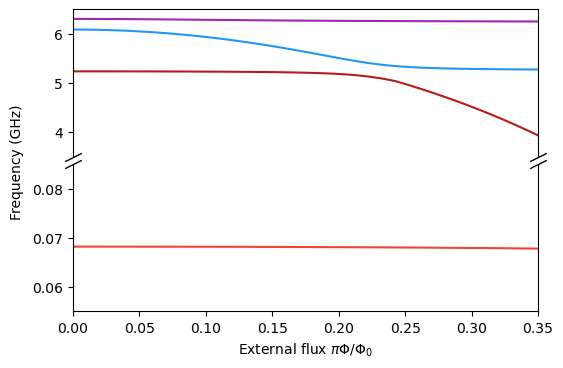

In [24]:
fluxbiases = np.linspace(0, 1, 100)
levels = np.arange(5)
init_ext_flux = system['transmon'].ext_flux

_eig_energies = bare_system.eig_energies()
_ground_state_energy = _eig_energies[0]
_sel_inds = [bare_system.state_index(state, _eig_energies) for state in comp_states]

_energies = []
for fluxbias in fluxbiases:
    system['transmon'].ext_flux = fluxbias
    _energies.append(system.eig_energies(levels=_sel_inds) - _ground_state_energy)
system['transmon'].ext_flux = init_ext_flux
    
flux_scan = xr.DataArray(_energies, dims=['ext_flux', 'state'], coords=dict(ext_flux=fluxbiases, state=comp_states))

fig, (top_ax, bot_ax) = plt.subplots(2, 1, sharex=True)
fig.subplots_adjust(hspace=0.05) 

for state, color in zip(['01'], ['#f44336']):
    bot_ax.plot(flux_scan.ext_flux, flux_scan.sel(state=state), color=color)

for state, color in zip(['02',  '10', '11'], ['#b71c1c', '#2196f3', '#9c27b0']):
    top_ax.plot(flux_scan.ext_flux, flux_scan.sel(state=state), color=color)

top_ax.set_ylim(3.5, 6.5)
bot_ax.set_ylim(0.055, 0.085)
bot_ax.set_xlim(0, 0.35)

top_ax.spines['bottom'].set_visible(False)
bot_ax.spines['top'].set_visible(False)
top_ax.tick_params(axis='x', bottom=False)
top_ax.tick_params(labeltop=False)
bot_ax.xaxis.tick_bottom()

d = .5
kwargs = dict(marker=[(-1, -d), (1, d)], markersize=12, linestyle="none", color='k', mec='k', mew=1, clip_on=False)
bot_ax.plot([0, 1], [1, 1], transform=bot_ax.transAxes, **kwargs)
top_ax.plot([0, 1], [0, 0], transform=top_ax.transAxes, **kwargs)

bot_ax.set_xlabel(r'External flux $\pi\Phi/\Phi_0$')
fig.text(0.02, 0.5, 'Frequency (GHz)', va='center', rotation='vertical')
    
plt.show()

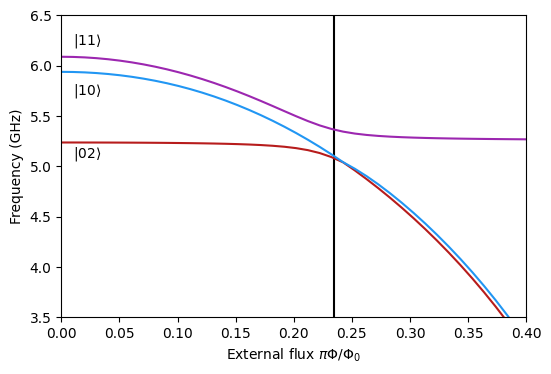

In [167]:
fluxbiases = np.linspace(0, 1, 100)
levels = np.arange(5)
init_ext_flux = system['transmon'].ext_flux

_eig_energies = bare_system.eig_energies()
_ground_state_energy = _eig_energies[0]
_sel_inds = [bare_system.state_index(state, _eig_energies) for state in comp_states]

_energies = []
for fluxbias in fluxbiases:
    system['transmon'].ext_flux = fluxbias
    _energies.append(system.eig_energies(levels=_sel_inds) - _ground_state_energy)
system['transmon'].ext_flux = init_ext_flux
    
flux_scan = xr.DataArray(_energies, dims=['ext_flux', 'state'], coords=dict(ext_flux=fluxbiases, state=comp_states))

fig, ax = plt.subplots()

for state, color in zip(['02',  '10', '11'], ['#b71c1c', '#2196f3', '#9c27b0']):
    ax.plot(flux_scan.ext_flux, flux_scan.sel(state=state), color=color)

ax.set_ylim(3.5, 6.5)
ax.set_xlim(0, 0.4)

ax.text(0.01, 5.125, r'$\left|02\right\rangle$', va='center', rotation='horizontal')
ax.text(0.01, 5.75, r'$\left|10\right\rangle$', va='center', rotation='horizontal')
ax.text(0.01, 6.25, r'$\left|11\right\rangle$', va='center', rotation='horizontal')

ax.vlines(0.235, ymin=3.5,  ymax=6.5)

ax.set_xlabel(r'External flux $\pi\Phi/\Phi_0$')
ax.set_ylabel('Frequency (GHz)')
    
plt.show()

# 1. Gate a la Ficheux 2020 and how it could work: flux tuning seems needed

In [52]:
# Fluxonium parameters (like Qubit A in Ficheux 2020): values in GHz (divided by h)
ec_f = 0.973 
el_f = 0.457 
ej_f = 5.899
flux_f = 1/2
n_fock_f = 100
levels_f = 7
flx = sq.qubits.Fluxonium('F', ec_f, el_f, ej_f, flux_f, dim_hilbert=n_fock_f)
flx.diagonalize_basis(levels_f)
energies_f = flx.eig_energies(levels_f)
delta_t = -0.3
n_fock_t = 3
levels_t = n_fock_t

In the following we plot the energy levels structure. The colors represent the strength of the matrix elements of the charge operators for each transition. 

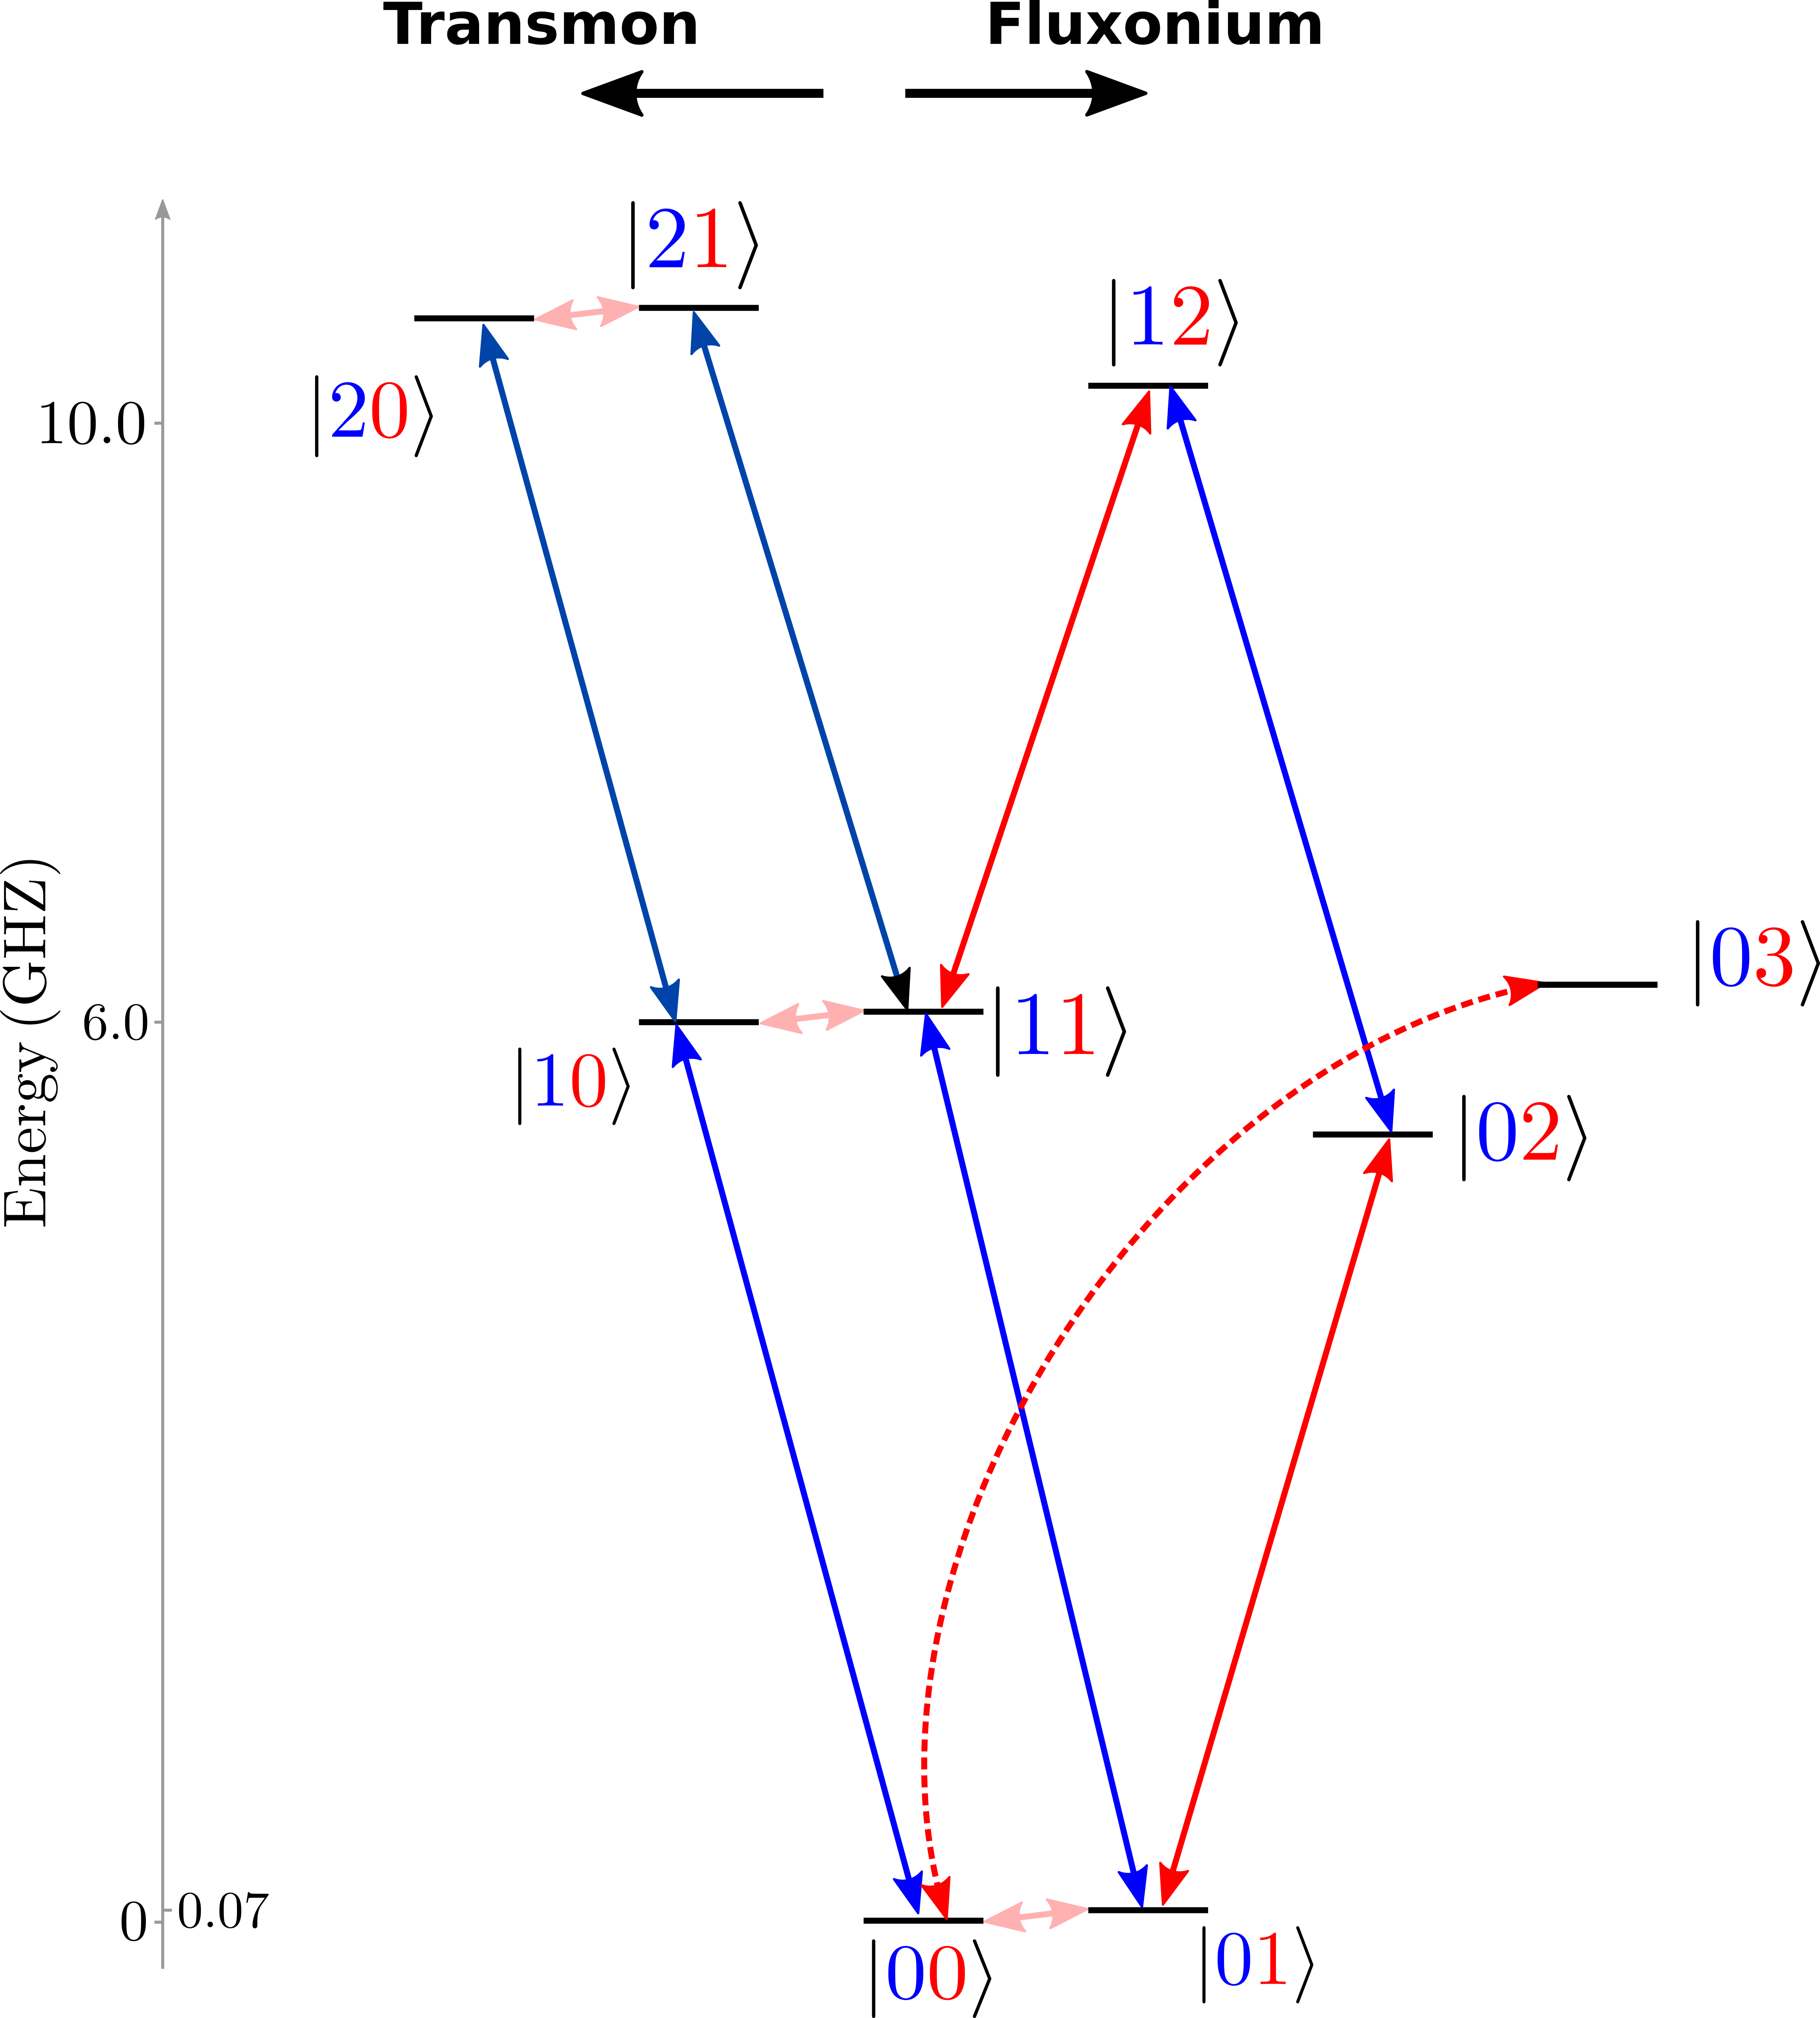

In [53]:
Image("transmon_fluxonium_levels.png", width = 500)

The following represents the strength of the couplings between the levels

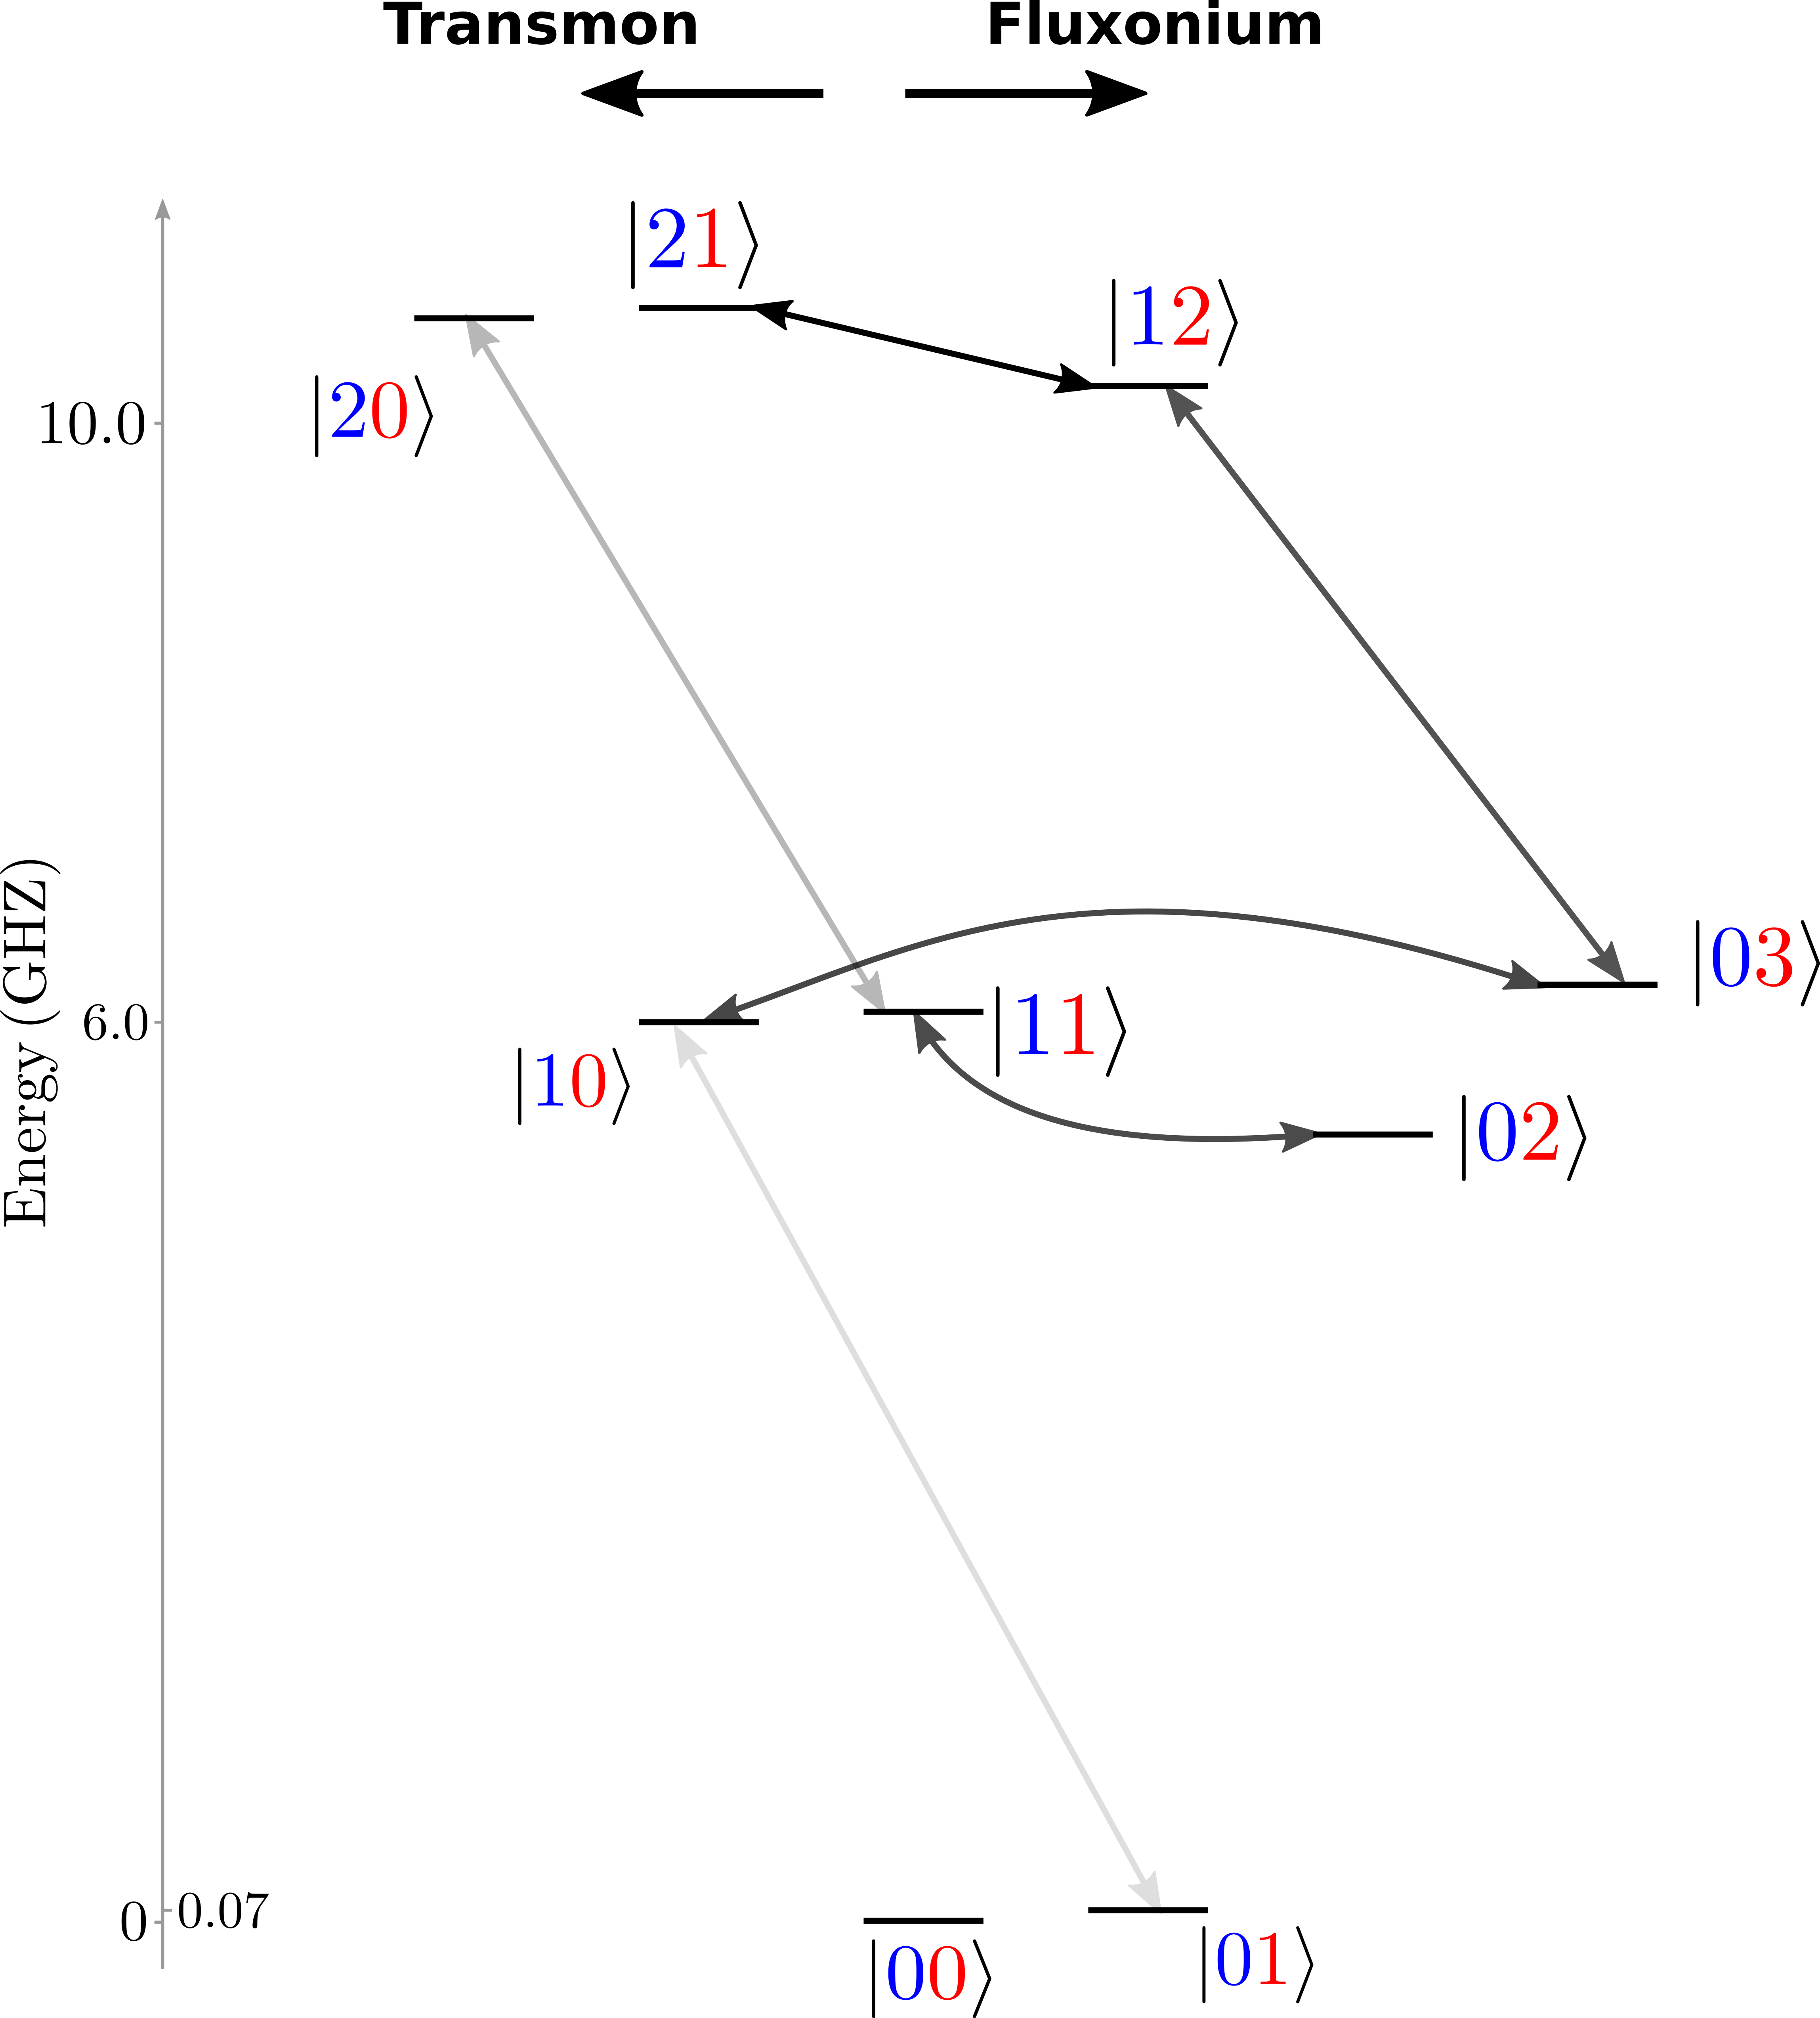

In [54]:
Image("transmon_fluxonium_couplings.png", width = 500)

In [55]:
def labels_to_energy(
    lev_t: int, 
    lev_f: int, 
    energies: np.ndarray, 
    label_converter: np.ndarray,
    n_levels_f=levels_f, 
    n_levels_t=n_fock_t, 
) -> float:
    if lev_t >= n_levels_t:
        raise ValueError("Transmon has to be smaller than the total number of transmon levels")
    if lev_f >= n_levels_f:
        raise ValueError("Fluxonium has to be smaller than the total number of fluxonium levels")
    label = lev_t*n_levels_f + lev_f
    index = np.where(label_converter==label)[0][0]
    return energies[index]

def zz(energy_mat):
    return energy_mat[1, 1] + energy_mat[0, 0] - energy_mat[1, 0] - energy_mat[0, 1]

def delta_ficheux(energy_mat):
    return (energy_mat[0, 2] - energy_mat[0, 1]) - (energy_mat[1, 2] - energy_mat[1, 1])

## Varying the frequency of the transmon

In [56]:
n_points = 1000
omega_vec = np.linspace(3.5, 7.5, n_points)
zz_coup_vec = np.zeros(n_points, dtype=float)
delta_f_vec = np.zeros(n_points, dtype=float)
jc = 0.224*0.1

The Ficheux gate is based on the fact that the frequency of the $\lvert 10 \rangle - \lvert 20 \rvert$ transition is different than the frequency of the $\lvert 11 \rangle - \lvert 21 \rvert$ transition. In particular, this frequency difference
$$
\Delta = \frac{\lvert (E_{20} - E_{10}) - (E_{21} - E_{11}) \rvert}{h},
$$
sets the gate time simply as $t_{\mathrm{gate}} = 1/\Delta $

In [57]:
start = time.time()

for i in range(0, n_points):
    trans_i = sq.qubits.SimpleTransmon('T', omega_vec[i], delta_t, dim_hilbert=n_fock_t)
    energies_ti, eig_states_ti = trans_i.eig_states(levels_t)
    flx_trans_i = trans_i.couple_to(flx, coupling=sq.couplers.capacitive_coupling, strength=jc)
    energies_i, eigstates_i = flx_trans_i.eig_states()
    bare_energies_i = np.zeros(levels_f*n_fock_t, dtype=float)
    count = 0
    for k in range(0, levels_t):
        for m in range(0, levels_f):
            bare_energies_i[count] = energies_ti[k] + energies_f[m]
            count += 1
    label_converter_i = np.argsort(bare_energies_i)
    en_mat_i = np.zeros([levels_t, levels_f], dtype=float)
    for lev_t in range(0, levels_t):
        for lev_f in range(0, levels_f):
            en_mat_i[lev_t, lev_f] = labels_to_energy(lev_t, lev_f, energies_i, label_converter_i)
    zz_coup_vec[i] = zz(en_mat_i)
    delta_f_vec[i] = delta_ficheux(en_mat_i)    

end=time.time()

print("Computation time: " + str(end - start) + ' s')

Computation time: 8.525424242019653 s


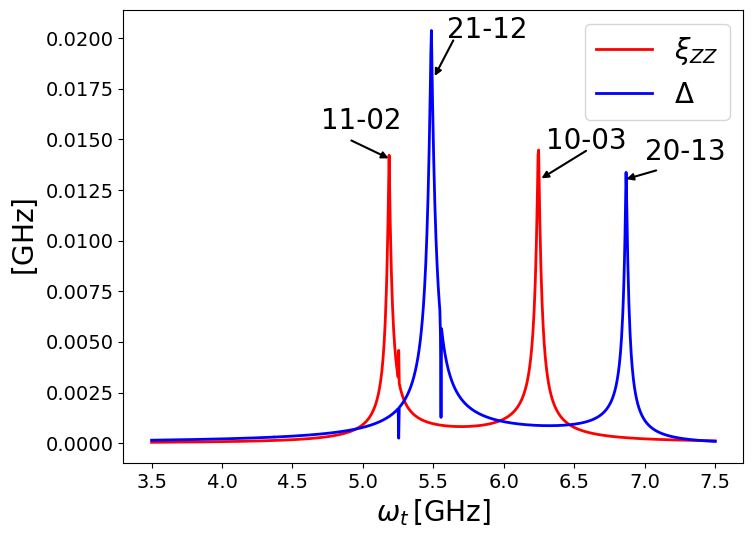

In [58]:
plot_setup = {'lw': 2.0, 'fs': 20, 'fs_text': 14, 'ls': 14}
def plot_zz_delta(
    omega_vec: np.ndarray,
    zz_coup_vec: np.ndarray,
    delta_f_vec: np.ndarray,
    opt: dict
) -> None:
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.plot(omega_vec, np.abs(zz_coup_vec), linewidth=opt['lw'], color='red', label='$\\xi_{ZZ}$')
    ax.plot(omega_vec, np.abs(delta_f_vec), linewidth=opt['lw'], color='blue', label='$\Delta$')
    ax.axes.set_xlabel("$\omega_t \, \mathrm{[GHz]}$", fontsize=opt['fs'])
    ax.axes.set_ylabel("$\mathrm{[GHz]}$", fontsize=opt['fs'])
    ax.tick_params(axis='both', labelsize=opt['ls'])
    ax.text(7.0, 0.014, '20-13', fontsize=opt['fs'])
    ax.annotate("", xy=(6.85, 0.013), xytext=(7.1, 0.0135), \
                arrowprops=dict(arrowstyle='-|>', linewidth=1.5, fc='k'))
    ax.text(6.3, 0.0145, '10-03', fontsize=opt['fs'])
    ax.annotate("", xy=(6.25, 0.013), xytext=(6.6, 0.0145), \
                arrowprops=dict(arrowstyle='-|>', linewidth=1.5, fc='k'))
    ax.text(5.6, 0.02, '21-12', fontsize=opt['fs'])
    ax.annotate("", xy=(5.5, 0.018), xytext=(5.65, 0.02), \
                arrowprops=dict(arrowstyle='-|>', linewidth=1.5, fc='k'))
    ax.text(4.7, 0.0155, '11-02', fontsize=opt['fs'])
    ax.annotate("", xy=(5.2, 0.014), xytext=(4.9, 0.015), \
                arrowprops=dict(arrowstyle='-|>', linewidth=1.5, fc='k'))    
    plt.legend(fontsize=opt['fs'])
    plt.show()
    
plot_zz_delta(omega_vec, zz_coup_vec, delta_f_vec, plot_setup)   

From the plot I conclude that there is no clear point where there is a separation between the  𝑍𝑍  coupling and the  Δ  parameter in the Ficheux paper like in a fluxonium-fluxonium system. The gate will have to deal with a  𝑍𝑍  coupling, and the smartest thing seems to to work with the transmon close to the right peak of the  Δ  parameter. There the  𝑍𝑍  coupling is small (about  300kHz ), but it is impossible to hit desired frequency out of fabrication. Thus one needs a bit of tunability of the transmon frequency and the result would be a microwave + flux-biased gate, which could be unappealling.

However, we also notice that the right peak of  𝜉𝑍𝑍  is clearly due to hybridization between the  |10⟩−|03⟩  transition which was at about

In [59]:
display(Latex(r'$\omega^{{f}}_{{{} \rightarrow {}}}/2 \pi$ = {:.3f} GHz'.format(0, 3, energies_f[3] - energies_f[0] )))

<IPython.core.display.Latex object>

This means that by placing the transmon above this frequency (say $6.8 \, \mathrm{GHz}$) we can perform a CPHASE-like gate by flux tuning at the interaction point of the $\lvert 10 \rangle-\lvert 03 \rangle$ transition. By correcting for single-qubit phases the gate would realize the unitary
$$
U = \begin{pmatrix}
1 & 0 & 0 & 0 \\
0 & 1 & 0 & 0 \\
0 & 0 & -1 & 0 \\
0 & 0 & 0 & 1
\end{pmatrix}
$$
which by applying the single-qubit unitary $Z \otimes I$ becomes the $\mathrm{CZ}$ gate. Also the gate speed seems comparable to the transmon-transmon case, but also the $ZZ$ coupling problem. Additionally, the gate loses the protection against relaxation of the fluxonium, but this is true for any fluxonium gate that uses the higher levels. Finally, by reducing the Josephson energy of the fluxonium $\omega_{03}^f$ can be reduced and we can accordingly take transmons with lower frequency. 

# 2. CPHASE-like gate using the $\lvert 10 \rangle-\lvert 03 \rangle$ transition

We consider a transmon that has an initial frequency of $6.8 \, \mathrm{GHz}$.

In [62]:
omega_in = 6.8
n_points = 1000
phi_vec = np.linspace(0.8, 1.0, n_points) #phi/phi_0
level_in_plot = 2
level_f_plot = 5
energy_phi_vec = np.zeros([level_f_plot - level_in_plot, n_points], dtype=float)
trans_in = sq.qubits.SimpleTransmon('T', omega_in, delta_t, dim_hilbert=n_fock_t)
energies_t_in = trans_in.eig_energies()
bare_energies_in = np.zeros(levels_f*n_fock_t, dtype=float)
count = 0
for k in range(0, levels_t):
    for m in range(0, levels_f):
        bare_energies_in[count] = energies_t_in[k] + energies_f[m]
        count += 1
label_converter_in = np.argsort(bare_energies_in)
bare_energy_mat_in = np.zeros([levels_t, levels_f], dtype=float)
for lev_t in range(0, levels_t):
    for lev_f in range(0, levels_f):
        bare_energy_mat_in[lev_t, lev_f] = labels_to_energy(lev_t, lev_f, np.sort(bare_energies_in), 
                                                         label_converter_in)

In [64]:
start = time.time()

for i in range(0, n_points):
    omega_phi = omega_in*np.sqrt(np.abs(np.cos(np.pi*phi_vec[i])))
    trans_phi = sq.qubits.SimpleTransmon('T', omega_phi, delta_t, dim_hilbert=n_fock_t)
    energies_phi, eig_states_phi = trans_phi.eig_states(levels_t)
    flx_trans_phi = trans_phi.couple_to(flx, coupling=sq.couplers.capacitive_coupling, strength=jc)
    energies_phi = flx_trans_phi.eig_energies()
    energy_phi_vec[:, i] = energies_phi[level_in_plot: level_f_plot]
    

end=time.time()

print("Computation time: " + str(end - start) + ' s')

Computation time: 10.068928718566895 s


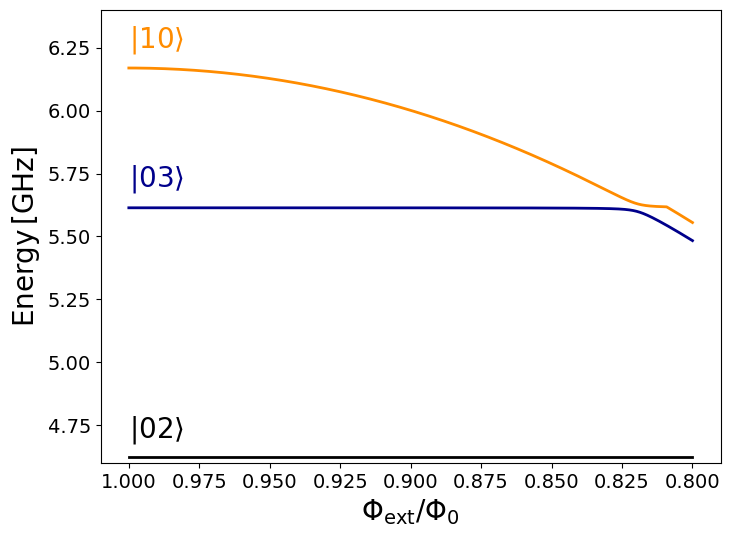

In [65]:
def plot_levels_phi(
    phi_vec: np.ndarray,
    energy_phi_vec: np.ndarray,
    opt: dict
) -> None:
    color_plot = ['black', 'darkblue', 'darkorange']
    fig, ax = plt.subplots(figsize=(8, 6))
    levels = energy_phi_vec.shape[0]
    for lev in range(0, levels):
        ax.plot(phi_vec, energy_phi_vec[lev, :], color=color_plot[lev], linewidth=opt['lw'])
    ax.axes.set_xlabel('$\Phi_{\mathrm{ext}}/\Phi_0$', fontsize=opt['fs'])
    ax.axes.set_ylabel('$\mathrm{Energy} \, [\mathrm{GHz}]$', fontsize=opt['fs'])
    ax.tick_params(axis='both', labelsize=opt['ls'])
    ax.text(1, 4.7, '$\\vert 02 \\rangle$', fontsize=opt['fs'], color=color_plot[0])
    ax.text(1, 5.7, '$\\vert 03 \\rangle$', fontsize=opt['fs'], color=color_plot[1])
    ax.text(1, 6.25, '$\\vert 10 \\rangle$', fontsize=opt['fs'], color=color_plot[2])
    ax.set_ylim(4.6, 6.4)
    plt.gca().invert_xaxis()
    plt.show()

plot_levels_phi(phi_vec, energy_phi_vec, plot_setup)